<strong>QuickSight Incremental Migration</strong>

Author: Ying Wang (Data Visualization Engineer in ProServe GSP)
Date: July 15 2020


In [ ]:
!pip install --upgrade pip
!pip install --upgrade boto3
get_ipython().system('pip install --upgrade ipynb')

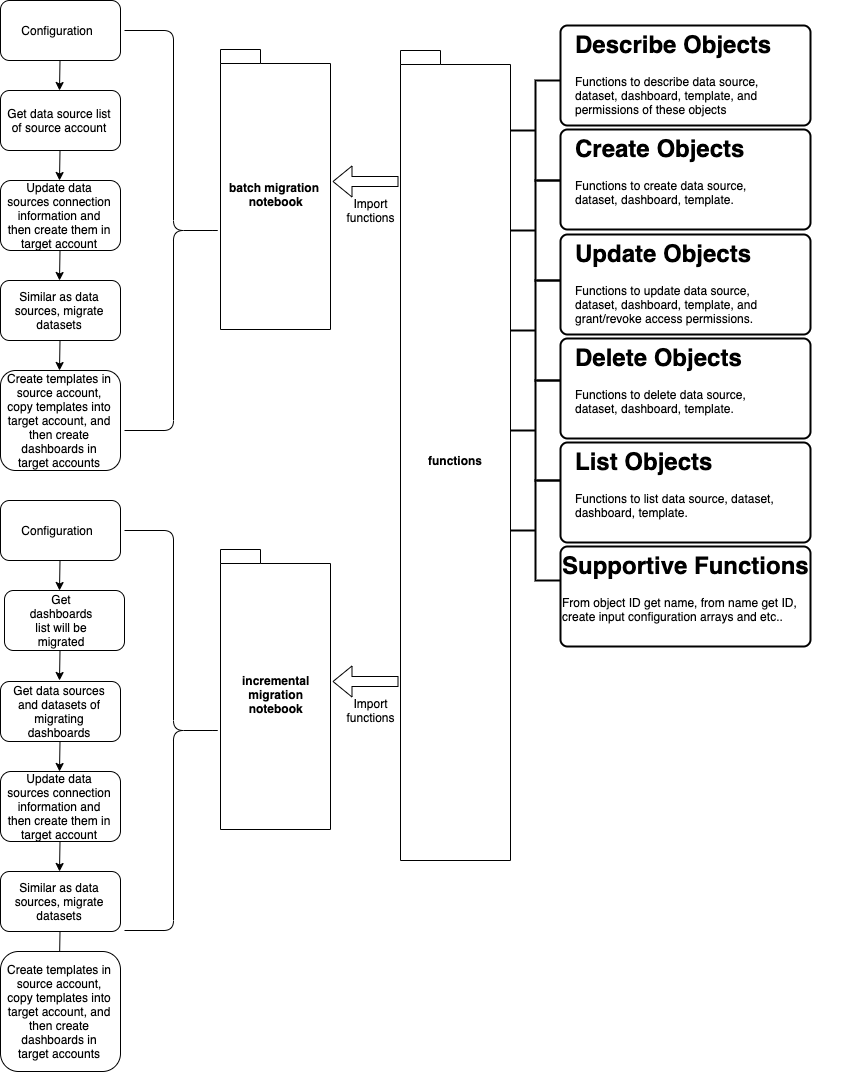

In [27]:
from IPython.display import Image
Image(filename = "img/Migration_Scripts.png", width=1024, height=1024)

In [1]:
import boto3
import json
import time
from IPython.display import JSON
import sys
import ipynb.fs 
import logging
from typing import Any, Dict, List, Optional
from datetime import datetime

# current date and time
now = str(datetime.now().strftime("%m-%d-%Y_%H_%M"))

Import functions from functions notebook

In [2]:
from ipynb.fs.defs.Functions import data_sources
from ipynb.fs.defs.Functions import describe_source 
from ipynb.fs.defs.Functions import delete_source
from ipynb.fs.defs.Functions import create_data_source
from ipynb.fs.defs.Functions import get_datasource_name
from ipynb.fs.defs.Functions import get_datasource_ids
from ipynb.fs.defs.Functions import update_data_source_permissions

from ipynb.fs.defs.Functions import get_dataset_name
from ipynb.fs.defs.Functions import data_sets
from ipynb.fs.defs.Functions import describe_dataset
from ipynb.fs.defs.Functions import get_dataset_ids
from ipynb.fs.defs.Functions import delete_dataset 
from ipynb.fs.defs.Functions import create_dataset
from ipynb.fs.defs.Functions import update_dataset
from ipynb.fs.defs.Functions import update_data_set_permissions

from ipynb.fs.defs.Functions import get_target

from ipynb.fs.defs.Functions import templates
from ipynb.fs.defs.Functions import delete_template
from ipynb.fs.defs.Functions import update_template_permission 
from ipynb.fs.defs.Functions import copy_template
from ipynb.fs.defs.Functions import describe_template
from ipynb.fs.defs.Functions import create_template 

from ipynb.fs.defs.Functions import dashboards
from ipynb.fs.defs.Functions import describe_dashboard
from ipynb.fs.defs.Functions import create_dashboard 
from ipynb.fs.defs.Functions import delete_dashboard
from ipynb.fs.defs.Functions import update_dashboard 
from ipynb.fs.defs.Functions import get_dashboard_ids
from ipynb.fs.defs.Functions import get_dashboard_name

#supportive functions
from ipynb.fs.defs.Functions import data_sets_ls_of_dashboard
from ipynb.fs.defs.Functions import data_sources_ls_of_dashboard
from ipynb.fs.defs.Functions import get_data_source_migration_list
from ipynb.fs.defs.Functions import get_user_arn
from ipynb.fs.defs.Functions import _assume_role

<strong>Static Profile</strong>

You can configure AWS profile from terminal and call the profile in below cell

In [3]:
sourceprofile=''
targetprofile=''
aws_region='us-east-1'
sourcesession = boto3.Session(profile_name=sourceprofile, region_name=aws_region)
targetsession = boto3.Session(profile_name=targetprofile, region_name=aws_region)


<strong>Assume Role</strong>

You can also assume an IAM role and create session based on the role permissions

In [ ]:
#source account
sourceaccountid=<account_id>
role_name=<role_name>
aws_region='us-east-1'
sourcesession = _assume_role(sourceaccountid, role_name, aws_region)

In [ ]:
#target account
targetaccountid=""
role_name=""
aws_region='us-east-1'
targetsession = _assume_role(targetaccountid, role_name, aws_region)
#targetsession = boto3.Session(
#        aws_access_key_id="",
#        aws_secret_access_key="",
#        aws_session_token="",
#        region_name=aws_region
#    )

<strong>Set root and admin users</strong>

root user is for the template. 
By default, we assign full permissions of objects to admin.

In [4]:
sourceroot=get_user_arn (sourcesession, 'root')
sourceadmin=get_user_arn (sourcesession, 'Administrator/wangzyn-Isengard')
#sourceversion='1'

targetroot=get_user_arn (targetsession, 'root')
targetadmin=get_user_arn (targetsession, 'Admin/wangzyn-Isengard')
#targetvpc='arn:aws:quicksight:us-east-1:889399602426:vpcConnection/sg-40b7521a'

<strong>Please define your input parameters in below cell</strong>

In [5]:
rds='mssql'
redshift={
    "ClusterId": 'wangzyncluster1',
    "Host": 'wangzyncluster1.coprq8ycemvc.us-east-1.redshift.amazonaws.com',
    "Database": 'dev'}

s3Bucket='spaceneedle-samplefiles.prod.us-east-1'
s3Key='sales/manifest.json'
vpc='sg-40b7521a'
tag=[
        {
            'Key': 'covid-19-dashboard-migration',
            'Value': 'true'
        }
    ]
owner=targetadmin
rdscredential={
        'CredentialPair': {
            'Username': "",
            'Password': ""}}
redshiftcredential={
        'CredentialPair': {
            'Username': "ro_user",
            'Password': "Ro_user1234"}}
region='us-east-1'
namespace='default'
version='1' 

target=get_target(targetsession, rds,redshift,s3Bucket,s3Key,vpc,tag,owner,rdscredential,redshiftcredential)

JSON(target)

<IPython.core.display.JSON object>

<strong>Migration List<strong/>

In [6]:
migrate_p = 'dashboard' 
""""
"all" will migrate data source, dataset and dashboard;
"source" means data sources only; 
"dataset" means datasets only; 
"dashboard" means dashboard only
""" 

source_migrate_list = ["redshift-auto", "mssql", "athena_1","redshift_manual"]
dataset_migrate_list = ["patient_info"]
dashboard_migrate_list = ["QuickSight_Access_Last_24_H", "Marketing Dashboard"]

In [8]:
if migrate_p in ['dashboard']:
    source_migrate_list=[]
    dataset_migrate_list=[]
    for dashboard in dashboard_migrate_list:
        print(dashboard)
        datasources=data_sources_ls_of_dashboard(dashboard, sourcesession)
        print(datasources)
        for datasource in datasources:
            source_migrate_list.append(datasource)
        datasets=data_sets_ls_of_dashboard(dashboard, sourcesession)
        print(datasets)
        for dataset in datasets:
            dataset_migrate_list.append(dataset)
    
if migrate_p in ['all']:
    for dashboard in dashboard_migrate_list:
        datasources=data_sources_ls_of_dashboard(dashboard, sourcesession)
        for datasource in datasources:
            source_migrate_list.append(datasource)
        datasets=data_sets_ls_of_dashboard(dashboard, sourcesession)
        for dataset in datasets:
            dataset_migrate_list.append(dataset)

QuickSight_Access_Last_24_H
['athena_1']
['quicksight_access_last_24h']
Marketing Dashboard
['redshift_manual']
['patient_info']


In [9]:
dashboard_migrate_list

['QuickSight_Access_Last_24_H', 'Marketing Dashboard']

In [10]:
dataset_migrate_list

['quicksight_access_last_24h', 'patient_info']

In [11]:
source_migrate_list

['athena_1', 'redshift_manual']

<strong>Results Output Location<strong/>

In [12]:
#
successlocation = "Migration_Results/Successful/"
faillocation = "Migration_Results/Fail/"

import os
try:
    os.makedirs(successlocation)
except OSError:
    print ("Creation of the directory %s failed" % successlocation)
else:
    print ("Successfully created the directory %s" % successlocation)

try:
    os.makedirs(faillocation)
except OSError:
    print ("Creation of the directory %s failed" % faillocation)
else:
    print ("Successfully created the directory %s" % faillocation)

Creation of the directory Migration_Results/Successful/ failed
Creation of the directory Migration_Results/Fail/ failed


<strong>Migrate data sources<strong/>

In [13]:
migration_list=get_data_source_migration_list(sourcesession,source_migrate_list)

In [14]:
#get data sources which already migrated
targetsources=data_sources(targetsession)

#already_migrated record the data source ids of target account
already_migrated=[]
for tsource in targetsources:
    already_migrated.append(tsource['DataSourceId'])

print(already_migrated)

['18e39ce0-57a8-483b-af1f-cfa43c2bd34b']


<strong>Create data sources in target account</strong>

In [15]:
faillist=[]
newsourceslist=[]
for i in migration_list:
    if i['DataSourceId'] not in already_migrated and 'DataSourceParameters' in i:
        print(i['DataSourceId'])
    #if 'DataSourceParameters' in i:
        newdsource=create_data_source (i, targetsession, target)
        if 'Error' in newdsource:
            faillist.append(newdsource)

        else: newsourceslist.append(newdsource)

73ebc3dd-d3b1-403f-8c99-d00b652edbf9
f1123c10-8a6a-4316-9475-a3efd163f539


<strong>Write migration results:</strong>

In [16]:
# Datasource_Creation_Error.json records the failure on create_data_source API call step
with open(faillocation+now+'_Datasource_Creation_Error.json', "w") as f:
            json.dump(faillist, f, indent=4, sort_keys=True, default=str)

#Datasource_Creation_Fail.json records the creation_failed status data sources
#Datasource_Creation_Success.json records the successful created data sources
faillist2=[]
successfulls=[]
for news in newsourceslist:
    datasource=describe_source(targetsession, news['DataSourceId'])

    if datasource['DataSource']['Status']=="CREATION_FAILED":
        delete_source (targetsession, news['DataSourceId'])
        faillist2.append(news['DataSourceId'])

    if datasource['DataSource']['Status']=="CREATION_SUCCESSFUL":
            successfulls.append(datasource['DataSource'])

    while datasource['DataSource']['Status']=="CREATION_IN_PROGRESS":
        time.sleep(5)
        datasource=describe_source(targetsession, news['DataSourceId'])
        if datasource['DataSource']['Status']=="CREATION_SUCCESSFUL":
            successfulls.append(datasource['DataSource'])
            break
        elif datasource['DataSource']['Status']=="CREATION_FAILED":
            delete_source (targetsession, news['DataSourceId'])
            faillist2.append(news['DataSourceId'])

with open(faillocation+now+'_Datasource_Creation_Fail.json', "w") as f:
    json.dump(faillist2, f, indent=4, sort_keys=True, default=str)

with open(successlocation+now+'_Datasource_Creation_Success.json', "w") as f:
    json.dump(successfulls, f, indent=4, sort_keys=True, default=str)


In [17]:
data_sources(targetsession)

[{'Arn': 'arn:aws:quicksight:us-east-1:387046087588:datasource/73ebc3dd-d3b1-403f-8c99-d00b652edbf9',
  'DataSourceId': '73ebc3dd-d3b1-403f-8c99-d00b652edbf9',
  'Name': 'athena_1',
  'Type': 'ATHENA',
  'Status': 'CREATION_SUCCESSFUL',
  'CreatedTime': datetime.datetime(2020, 8, 12, 14, 37, 53, 530000, tzinfo=tzlocal()),
  'LastUpdatedTime': datetime.datetime(2020, 8, 12, 14, 37, 56, 305000, tzinfo=tzlocal()),
  'DataSourceParameters': {'AthenaParameters': {'WorkGroup': 'primary'}},
  'SslProperties': {'DisableSsl': False}},
 {'Arn': 'arn:aws:quicksight:us-east-1:387046087588:datasource/f1123c10-8a6a-4316-9475-a3efd163f539',
  'DataSourceId': 'f1123c10-8a6a-4316-9475-a3efd163f539',
  'Name': 'redshift_manual',
  'Type': 'REDSHIFT',
  'Status': 'CREATION_SUCCESSFUL',
  'CreatedTime': datetime.datetime(2020, 8, 12, 16, 38, 44, 224000, tzinfo=tzlocal()),
  'LastUpdatedTime': datetime.datetime(2020, 8, 12, 16, 38, 45, 159000, tzinfo=tzlocal()),
  'DataSourceParameters': {'RedshiftParamete

Get datasets list:

#source account
sourceaccountid=""
role_name=""
aws_region=''
sourcesession = _assume_role(sourceaccountid, role_name, aws_region)

#target account
targetaccountid=""
role_name=""
aws_region='us-east-1'
targetsession = _assume_role(targetaccountid, role_name, aws_region)

In [17]:
datasets=data_sets(sourcesession)

migration_list=[]
for newset in dataset_migrate_list:
        ids = get_dataset_ids(newset, sourcesession)  #Get id of datasets migration list
        for dataset in datasets:
            if ids[0] == dataset["DataSetId"]:
                migration_list.append(dataset)

JSON(migration_list)

<IPython.core.display.JSON object>

<strong>Get already migrated datasets list</strong>

In [19]:
#get datasets which already migrated
targetds=data_sets(targetsession)
#already_migrated record the datasets ids of target account
already_migrated=[]
for ds in targetds:
    already_migrated.append(ds['DataSetId'])
#already_migrated

Migrate Datasets

In [20]:
newsetslist=[]
faillist=[]
sts_client = targetsession.client("sts")
account_id = sts_client.get_caller_identity()["Account"]
for mds in migration_list:
    if mds['DataSetId'] not in already_migrated:
        try:
            res=describe_dataset(sourcesession, mds['DataSetId'])
        except Exception:
            faillist.append({"Dataset": mds, "Error": str(Exception)})
            continue
   
        name=mds['Name']
        datasetid=mds['DataSetId']

        PT=res['DataSet']['PhysicalTableMap']
        for key, value in PT.items():
            for k,v in value.items():
                dsid = v['DataSourceArn'].split("/")[1]
                v['DataSourceArn']='arn:aws:quicksight:us-east-1:'+account_id+':datasource/'+dsid

        LT=res['DataSet']['LogicalTableMap']
        if 'ColumnGroups' in res['DataSet']:
            ColumnGroups=res['DataSet']['ColumnGroups']
        else: ColumnGroups=None
        try: 
            newdataset=create_dataset(targetsession, datasetid, name, PT, LT, res['DataSet']['ImportMode'], target['datasetpermission'],ColumnGroups)
            #print("new dataset: ", newdataset)
            newsetslist.append(newdataset)
        except Exception as e:
            #print('failed: '+str(e))
            faillist.append({"DataSetId": datasetid, "Name": name, "Error": str(e)})

            continue
            
    if mds['DataSetId'] in already_migrated:
        try:
            res=describe_dataset(sourcesession, mds['DataSetId'])
        except Exception:
            faillist.append({"Dataset": mds, "Error": str(Exception)})
            continue
 
        name=mds['Name']
        datasetid=mds['DataSetId']

        PT=res['DataSet']['PhysicalTableMap']
        for key, value in PT.items():
            for k,v in value.items():
                dsid = v['DataSourceArn'].split("/")[1]
                v['DataSourceArn']='arn:aws:quicksight:us-east-1:'+account_id+':datasource/'+dsid

        LT=res['DataSet']['LogicalTableMap']
        if 'ColumnGroups' in res['DataSet']:
            ColumnGroups=res['DataSet']['ColumnGroups']
        else: ColumnGroups=None
        try: 
            newdataset=update_dataset(targetsession, datasetid, name, PT, LT, res['DataSet']['ImportMode'],ColumnGroups)
            #print("new dataset: ", newdataset)
            newsetslist.append(newdataset)
        except Exception as e:
            #print('failed: '+str(e))
            faillist.append({"DataSetId": datasetid, "Name": name, "Error": str(e)})

            continue
            

In [21]:
#print fail informations
with open(faillocation+now+'Dataset_Creation_Error.json', "w") as f:
            json.dump(faillist, f, indent=4, sort_keys=True, default=str)

successfulls=[]
for news in newsetslist:
    dataset=describe_dataset(targetsession, news['DataSetId'])
    successfulls.append(dataset['DataSet'])
    
with open(successlocation+now+'Datasets_Creation_Success.json', "w") as f:
    json.dump(successfulls, f, indent=4, sort_keys=True, default=str)


Get dashboards list

#source account
sourceaccountid=""
role_name=""
aws_region='us-east-1'
sourcesession = _assume_role(sourceaccountid, role_name, aws_region)

#target account
targetaccountid=""
role_name=""
aws_region='us-east-1'
targetsession = _assume_role(targetaccountid, role_name, aws_region)

In [24]:
sourcedashboards=dashboards(sourcesession)

#Get id of datasets migration list
migration_list=[]
for newset in dashboard_migrate_list:
        ids = get_dashboard_ids(newset, sourcesession)
        for dashboard in sourcedashboards:
            if ids[0] == dashboard["DashboardId"]:
                migration_list.append(dashboard)

JSON(migration_list)

<IPython.core.display.JSON object>

Migrate dashboards

In [25]:
success=[]
faillist=[]
for dashboard in migration_list:
    sourcedashboard=describe_dashboard(sourcesession, dashboard['DashboardId'])
    SourceEntityArn=sourcedashboard['Dashboard']['Version']['SourceEntityArn']
    if SourceEntityArn.split("/")[0].split(":")[-1]=="analysis":
        sourceanalysis=sourcedashboard['Dashboard']['Version']['SourceEntityArn']
    else: 
        faillist.append({"Error Type": "Source Analysis is missing!","DashboardId": sourcetid, "Name": sourcetname, "Error": "Source Analysis is missing!"})
        continue
    sourceversion=sourcedashboard['Dashboard']['Version']['VersionNumber']
    sourcedid=sourcedashboard['Dashboard']['DashboardId']
    sourcedname=sourcedashboard['Dashboard']['Name']
    sourcetid=sourcedid
    sourcetname=sourcedname
    targettid=sourcetid
    targettname=sourcedname
    DataSetArns=sourcedashboard['Dashboard']['Version']['DataSetArns']
    sourcedsref = []
    #print(sourcedname)
    for i in DataSetArns:
        missing=False
        did = i.split("/")[1]
        try:
            dname=get_dataset_name(did, sourcesession)
        except Exception as e:
            faillist.append({"Error Type": "Dataset: "+did+" is missing!","DashboardId": sourcetid, "Name": sourcetname, "Error": str(e)})
            missing=True
            break
            
        sourcedsref.append({'DataSetPlaceholder': dname,
                    'DataSetArn': i})
    if missing: continue
    try:
        sourcetemplate = create_template(sourcesession, sourcetid, sourcetname, sourcedsref, sourceanalysis, '1')
        sourcetemplate=describe_template(sourcesession,sourcetid)
    except Exception as e:
        faillist.append({"Error Type": "Create Source Template Error","DashboardId": sourcetid, "Name": sourcetname, "Error": str(e)})
        continue
    
    while sourcetemplate['Template']['Version']['Status']=="CREATION_IN_PROGRESS":
        time.sleep(5)
        sourcetemplate=describe_template(sourcesession,sourcetid)
        if sourcetemplate['Template']['Version']['Status']=="CREATION_SUCCESSFUL":
            try:
                updateres=update_template_permission(sourcesession, sourcetid, targetroot)
            except Exception as e:
                delete_template(sourcesession, sourcetid)
                faillist.append({"Error Type": "Update Source Template Permission Error",
                                 "DashboardId": sourcetid, 
                                 "Name": sourcetname, 
                                 "Error": str(e)})
    else: 
        if sourcetemplate['Template']['Version']['Status']=="CREATION_SUCCESSFUL":
            try:
                updateres=update_template_permission(sourcesession, sourcetid, targetroot)
            except Exception as e:
                delete_template(sourcesession, sourcetid)
                faillist.append({"Error Type": "Update Source Template Permission Error",
                                 "DashboardId": sourcetid, 
                                 "Name": sourcetname, 
                                 "Error": str(e)})
                continue

    if updateres['Status']==200:
        try:
            targettemplate=copy_template(targetsession, targettid, targettname, updateres['TemplateArn'])
        except Exception as e:
            delete_template(sourcesession, sourcetid)
            faillist.append({"Error Type": "Copy Template Error",
                             "DashboardId": sourcetid, 
                             "Name": sourcetname, 
                             "Error": str(e)}) 
            continue
    else: 
        delete_template(sourcesession, sourcetid)
        faillist.append({"Error Type": "Update Source Template Permission Error",
                                 "DashboardId": sourcetid, 
                                 "Name": sourcetname, 
                                 "Error": str(e)})
        continue
    
    targettemplate=describe_template(targetsession,targettid)
   
    while targettemplate['Template']['Version']['Status']=="CREATION_IN_PROGRESS":
        time.sleep(5)
        targettemplate=describe_template(targetsession,targettid)
        if targettemplate['Template']['Version']['Status']=="CREATION_SUCCESSFUL":
            break
    else: 
        if targettemplate['Template']['Version']['Status']=="CREATION_SUCCESSFUL":
            print("Template is successful copied!")
        else: 
            delete_template(targetsession, targettid)
            faillist.append({"Error Type": "Copy Template Error",
                                 "DashboardId": sourcetid, 
                                 "Name": sourcetname, 
                                 "Error": str(e)})
            continue
    
    ds=data_sets (targetsession)
    Template=targettemplate['Template']
    dsref=[]
    #print(Template['Version']['DataSetConfigurations'])
    missing=False
    for i in Template['Version']['DataSetConfigurations']:
        #print("i is "+str(i))
        n=Template['Version']['DataSetConfigurations'].index(i)
        #print("n is "+str(n))
        for j in ds:
            if i['Placeholder']==j['Name']:
                print(j['Name'])
                dsref.append({
                    'DataSetPlaceholder': i['Placeholder'],
                    'DataSetArn': j['Arn']
                })
                break
                print("len of dsref is "+str(len(dsref)))
                print(dsref)
        if (n+1)>len(dsref): 
            e="Dataset "+i['Placeholder']+" is missing!"
            faillist.append({"Error Type": "Datasets in target env are missing for this dashboard",
                                 "DashboardId": sourcetid, 
                                 "Name": sourcetname, 
                                 "Error": str(e)})
            missing=True
            break
        if missing: break
    if missing: continue
    #print("len of dsref is "+str(len(dsref)))
    #print(dsref)    
    SourceEntity={
        'SourceTemplate': {
            'DataSetReferences': dsref,
            'Arn': Template['Arn']
        }
    }
    #print(SourceEntity)
    dashboard=describe_dashboard(targetsession, targettid)

    if 'Faild to describe dashboard:' in dashboard:
        if 'dashboard/'+targettid+' is not found' in dashboard:
            print("Create new dashboard now:")
            try:
                newdashboard=create_dashboard(targetsession, targettid, targettname,targetadmin, SourceEntity, '1', filter='ENABLED',csv='ENABLED', sheetcontrol='COLLAPSED')
            except Exception as e:
                delete_template(targetsession, targettid)
                faillist.append({"Error Type": "Create New Dashboard Error",
                                 "DashboardId": targettid, 
                                 "Name": targettname, 
                                 "Error": str(e)}) 
                continue
        else: 
            faillist.append({"Error Type": "Describe Target Dashboard Error",
                                 "DashboardId": targettid, 
                                 "Name": targettname, 
                                 "Error": str(dashboard)}) 
            continue
    elif dashboard['Dashboard']['Version']['Status']=="CREATION_FAILED":
        res=delete_dashboard(targetsession, targettid)
        try:
            newdashboard=create_dashboard(targetsession, targettid, targettname,targetadmin, SourceEntity, '1', filter='ENABLED',csv='ENABLED', sheetcontrol='COLLAPSED')
        except Exception as e:
            delete_template(targetsession, targettid)
            faillist.append({"Error Type": "Create Dashboard Error",
                                 "DashboardId": targettid, 
                                 "Name": targettname, 
                                 "Error": str(e)})
            continue
            
    else:
        print("dashboard is existing. update it now.")
        try:
            newdashboard=update_dashboard(targetsession, targettid, targettname, SourceEntity, target['version'], filter='ENABLED',csv='ENABLED', sheetcontrol='EXPANDED')
        except Exception as e:
            delete_template(targetsession, targettid)
            faillist.append({"Error Type": "Update Dashboard Error",
                                 "DashboardId": targettid, 
                                 "Name": targettname, 
                                 "Error": str(e)})
            continue

    res=describe_dashboard(targetsession,newdashboard['DashboardId'])
    
    if res['Status']==200:
        status=res['Dashboard']['Version']['Status']
        if status=='CREATION_SUCCESSFUL' or status=='UPDATE_SUCCESSFUL':
            success.append(res['Dashboard'])
            #filename="Migration_Results/Successful/Dashboard_"+res['Dashboard']['Name']+".json"
        else:
            faillist.append({"Error Type": "Dashboard Creation Status is not Successful", "Dashboard": res['Dashboard']})

            #filename="Migration_Results/Fail/Dashboard_"+res['Dashboard']['Name']+".json"

Template is successful copied!
quicksight_access_last_24h
Create new dashboard now:
Template is successful copied!
patient_info
Create new dashboard now:


In [26]:
with open(faillocation+now+'Dashboard_Error.json', "w") as f:
            json.dump(faillist, f, indent=4, sort_keys=True, default=str)

with open(successlocation+now+'Dashboard_Success.json', "w") as f:
    json.dump(success, f, indent=4, sort_keys=True, default=str)


<strong>Delete objects<strong/>

# THIS WILL DELETE ALL TARGET DATASETS

delete = "template"

if delete == "datasource":   
    for datasource in data_sources(targetsession):
        #if datasource['Type'] == "REDSHIFT":
        try:
            delete_source (targetsession, datasource['DataSourceId'])
        except Exception: pass 
elif delete == "dataset":
    for dataset in data_sets(targetsession):
        delete_dataset (targetsession, dataset['DataSetId'])
elif delete == "template":    
    for template in templates(targetsession):
        delete_template(targetsession, template['TemplateId'])
elif delete == "dashboard":    
    for dashboard in dashboards(targetsession):
        delete_dashboard(targetsession, dashboard['DashboardId'])
delete ="don't delete anything"

Schedule notebooks to execute

https://aws.amazon.com/blogs/machine-learning/scheduling-jupyter-notebooks-on-sagemaker-ephemeral-instances/